# Тема: "Машинное обучение в задачах распознавания голоса"

# Выполнил: Олейников Александр Александрович
## Группа: ПМ22-1
## Научный руководитель: Ахмад Авс 

# Введение

**Актуальность**
В современном мире технологии машинного обучения и искусственного интеллекта играют ключевую роль в различных областях человеческой деятельности. Одной из таких областей является распознавание голоса, которое находит применение в самых разных сферах: от голосовых помощников и систем управления умным домом до медицинской диагностики и обеспечения безопасности.

**Объект исследования**
В данной работе мы рассмотрим некоторые архитектуры нейросетей и их преимущества для решения задачи распознавания речи, а именно Quartznet, Conformer, Contextnet.

**Задачи**

1. Изучить историю методов и алгоритмов, используемых для распознавания голоса.

2. Проанализировать наиболее популярные архитектуры.

3. Оценить эффективность этих систем и определить наилучшие варианты применения данных архитектур. 

Распознавание голоса представляет собой процесс преобразования речи в текст. Это сложная задача, требующая учёта множества факторов, таких как особенности произношения, фоновый шум, акценты и т.д. Однако благодаря развитию технологий машинного обучения, стало возможным создание эффективных алгоритмов, способных справляться с этими трудностями.

# Краткая историческая справка

Первые полноценные алоритмы распознавания речи появились в 1980-х годах. Они основывались на скрытых марковских моделях (HMM) это статистический метод. И только в 2009 году нейросети победили классические алгоритмы.

# Основные подходы к решению задачи распознавания голоса:
1. Гибридная архитектура (Hybrid ASR) состоит из акустичекой модели и языковой модели которые работают независимо
2. end2end архитектура сразу переводит последовательность звуков в последовательность букв(seq2seq)

В данной работе представленны 3 различные end2end архитектуры

In [3]:
from datasets import load_dataset
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from torch.utils.data.sampler import RandomSampler, BatchSampler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
# from huggingsound import SpeechRecognitionModel
import warnings
import inspect
#import werpy
import librosa
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from tqdm import tqdm 
import nemo
import IPython.display as ipd
import nemo.collections.asr as nemo_asr
import pytorch_lightning as pl
warnings.filterwarnings('ignore')
import json
from ruamel.yaml import YAML
import time

**Loading_dataset**

In [4]:
data = load_dataset("google/fleurs", "en_us")  

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Для входных данных модели в основном принимают не просту волну звука или закодированный эмбеддинг, а мел - спектрограмму - картинка полученная после преобразований фурье

## **Спектрограммы**

In [5]:
sgram = librosa.stft(data['train'][0]['audio']['array'])
sample_rate = 16000

In [6]:
sgram_mag, _ = librosa.magphase(sgram)

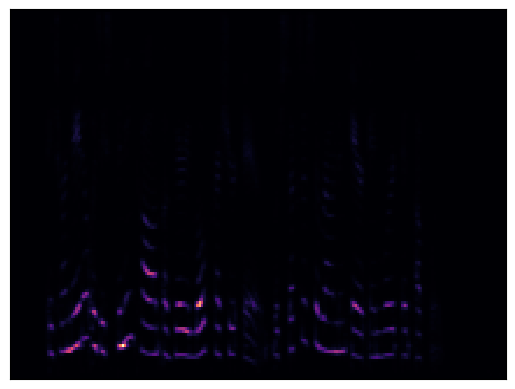

In [7]:
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
librosa.display.specshow(mel_scale_sgram)

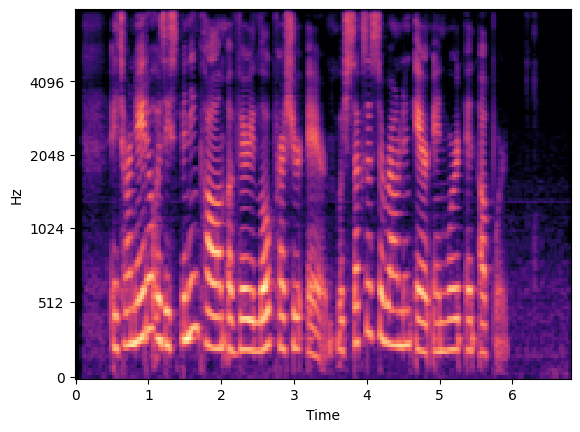

In [8]:
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
#plt.colorbar(format='%+2.0f dB')

**Installing packeges**

In [ ]:
# !apt-get install sox libsndfile1 ffmpeg
# !pip install text-unidecode

In [4]:
# BRANCH = 'main'
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

In [5]:
# pip install botcore

**preparing_dataset**

In [10]:
my_data_train = data['train']
my_data_test = data['test']

In [11]:
train_wavs = []
for i in range(len(data['train'])):
    train_wavs.append('/kaggle/input/fleurs-dataset/train/' + data['train'][i]['audio']['path'])
test_wavs = []
for i in range(len(data['test'])):
    test_wavs.append('/kaggle/input/fleurs-dataset/test/' + data['test'][i]['audio']['path'])
val_wavs = []
for i in range(len(data['validation'])):
    val_wavs.append('/kaggle/input/fleurs-dataset/dev/' + data['validation'][i]['audio']['path'])

In [12]:
train_transcriptions = np.array(my_data_train['transcription'])
test_transcriptions = np.array(my_data_test['transcription'])
train_num_samples = np.array(my_data_train['num_samples'])
train_durations = train_num_samples/16000
test_num_samples = np.array(my_data_test['num_samples'])
test_durations = test_num_samples/16000
train_wavs = np.array(train_wavs)
test_wavs = np.array(test_wavs)

Уберём из датасета аудифайлы длиннее 20 секунд

In [13]:
train_transcriptions = train_transcriptions[train_durations < 20]
test_transcriptions = test_transcriptions[test_durations < 20]
train_num_samples = train_num_samples[train_durations < 20]
test_num_samples = test_num_samples[test_durations < 20]
train_wavs = train_wavs[train_durations < 20]
test_wavs = test_wavs[test_durations < 20]
test_durations = test_durations[test_durations < 20]
train_durations = train_durations[train_durations < 20]

Функция для создания собственного датасета, чтобы вскоре обучать на нём модель из nemo

In [ ]:
import json

def build_manifest(transcripts, manifest_path, audio_path):
    with open(manifest_path, 'w') as fout:
        for i in range(len(transcripts)):
            audio = audio_path[i]
            trans = transcripts[i]
            duration = librosa.core.get_duration(filename=audio)

            metadata = {
                "audio_filepath": audio,
                "duration": duration,
                "text": trans
            }
            json.dump(metadata, fout)
            fout.write('\n')
                
print("******")
train_manifest = '/kaggle/working/train_manifest.json'
build_manifest(train_transcriptions, train_manifest, train_wavs)
print("Training manifest created.")

test_manifest = '/kaggle/working/test_manifest.json'
build_manifest(test_transcriptions, test_manifest, test_wavs)
print("Test manifest created.")
print("***Done***")

# Модели

**Lossы**

**CTC loss**

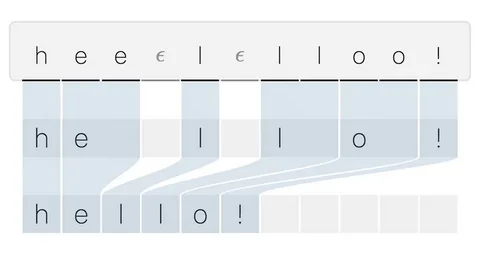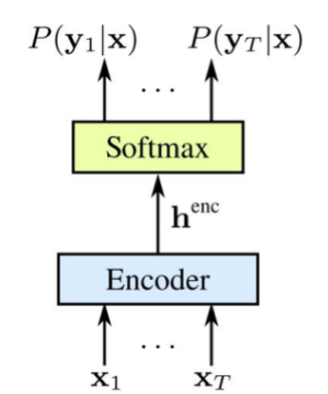

**RNNT**

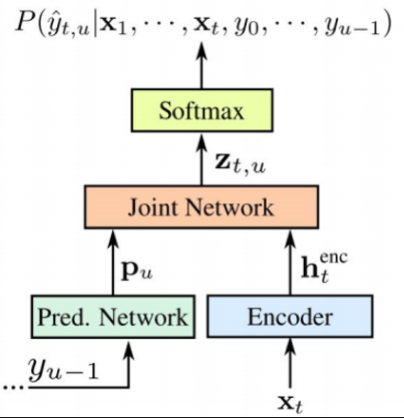

**Qaurtznet**

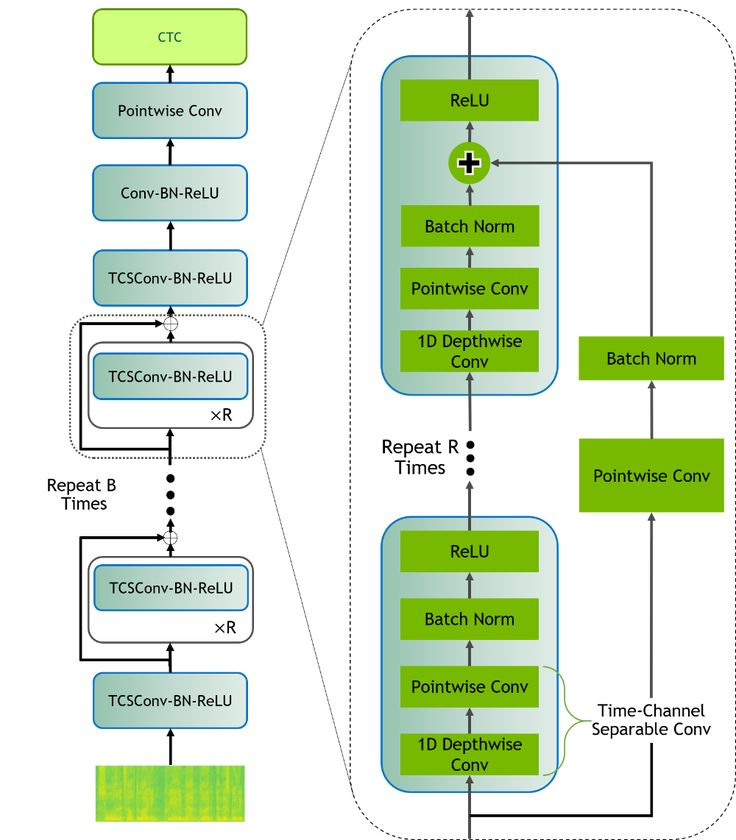

Работа предобученной модели 

In [14]:
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2024-06-03 09:41:06 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo to /root/.cache/torch/NeMo/NeMo_2.0.0rc1/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2024-06-03 09:41:08 common:826] Instantiating model from pre-trained checkpoint
[NeMo I 2024-06-03 09:41:10 features:305] PADDING: 16
[NeMo I 2024-06-03 09:41:11 save_restore_connector:263] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.0.0rc1/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


In [34]:
start_quartznet = time.time()
quartznet_predict_transcriptions = []
for i in test_wavs:
    quartznet_predict_transcriptions.append(quartznet.transcribe(audio = i, verbose = False)[0])
end_quartznet = time.time()
total_quartznet = end_quartznet - start_quartznet

Обучение на собственном датасете

In [ ]:
yaml = YAML(typ='safe')
with open('/kaggle/input/quartznet/quartznet_15x5.yaml') as f:
    params = yaml.load(f)
print(params)

In [ ]:
trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=50)

In [ ]:
from omegaconf import DictConfig
params['model']['train_ds']['manifest_filepath'] = train_manifest
params['model']['validation_ds']['manifest_filepath'] = test_manifest
first_asr_model = nemo_asr.models.EncDecCTCModel(cfg=DictConfig(params['model']), trainer=trainer)

In [ ]:
trainer.fit(first_asr_model)

**Conformer_CTC**

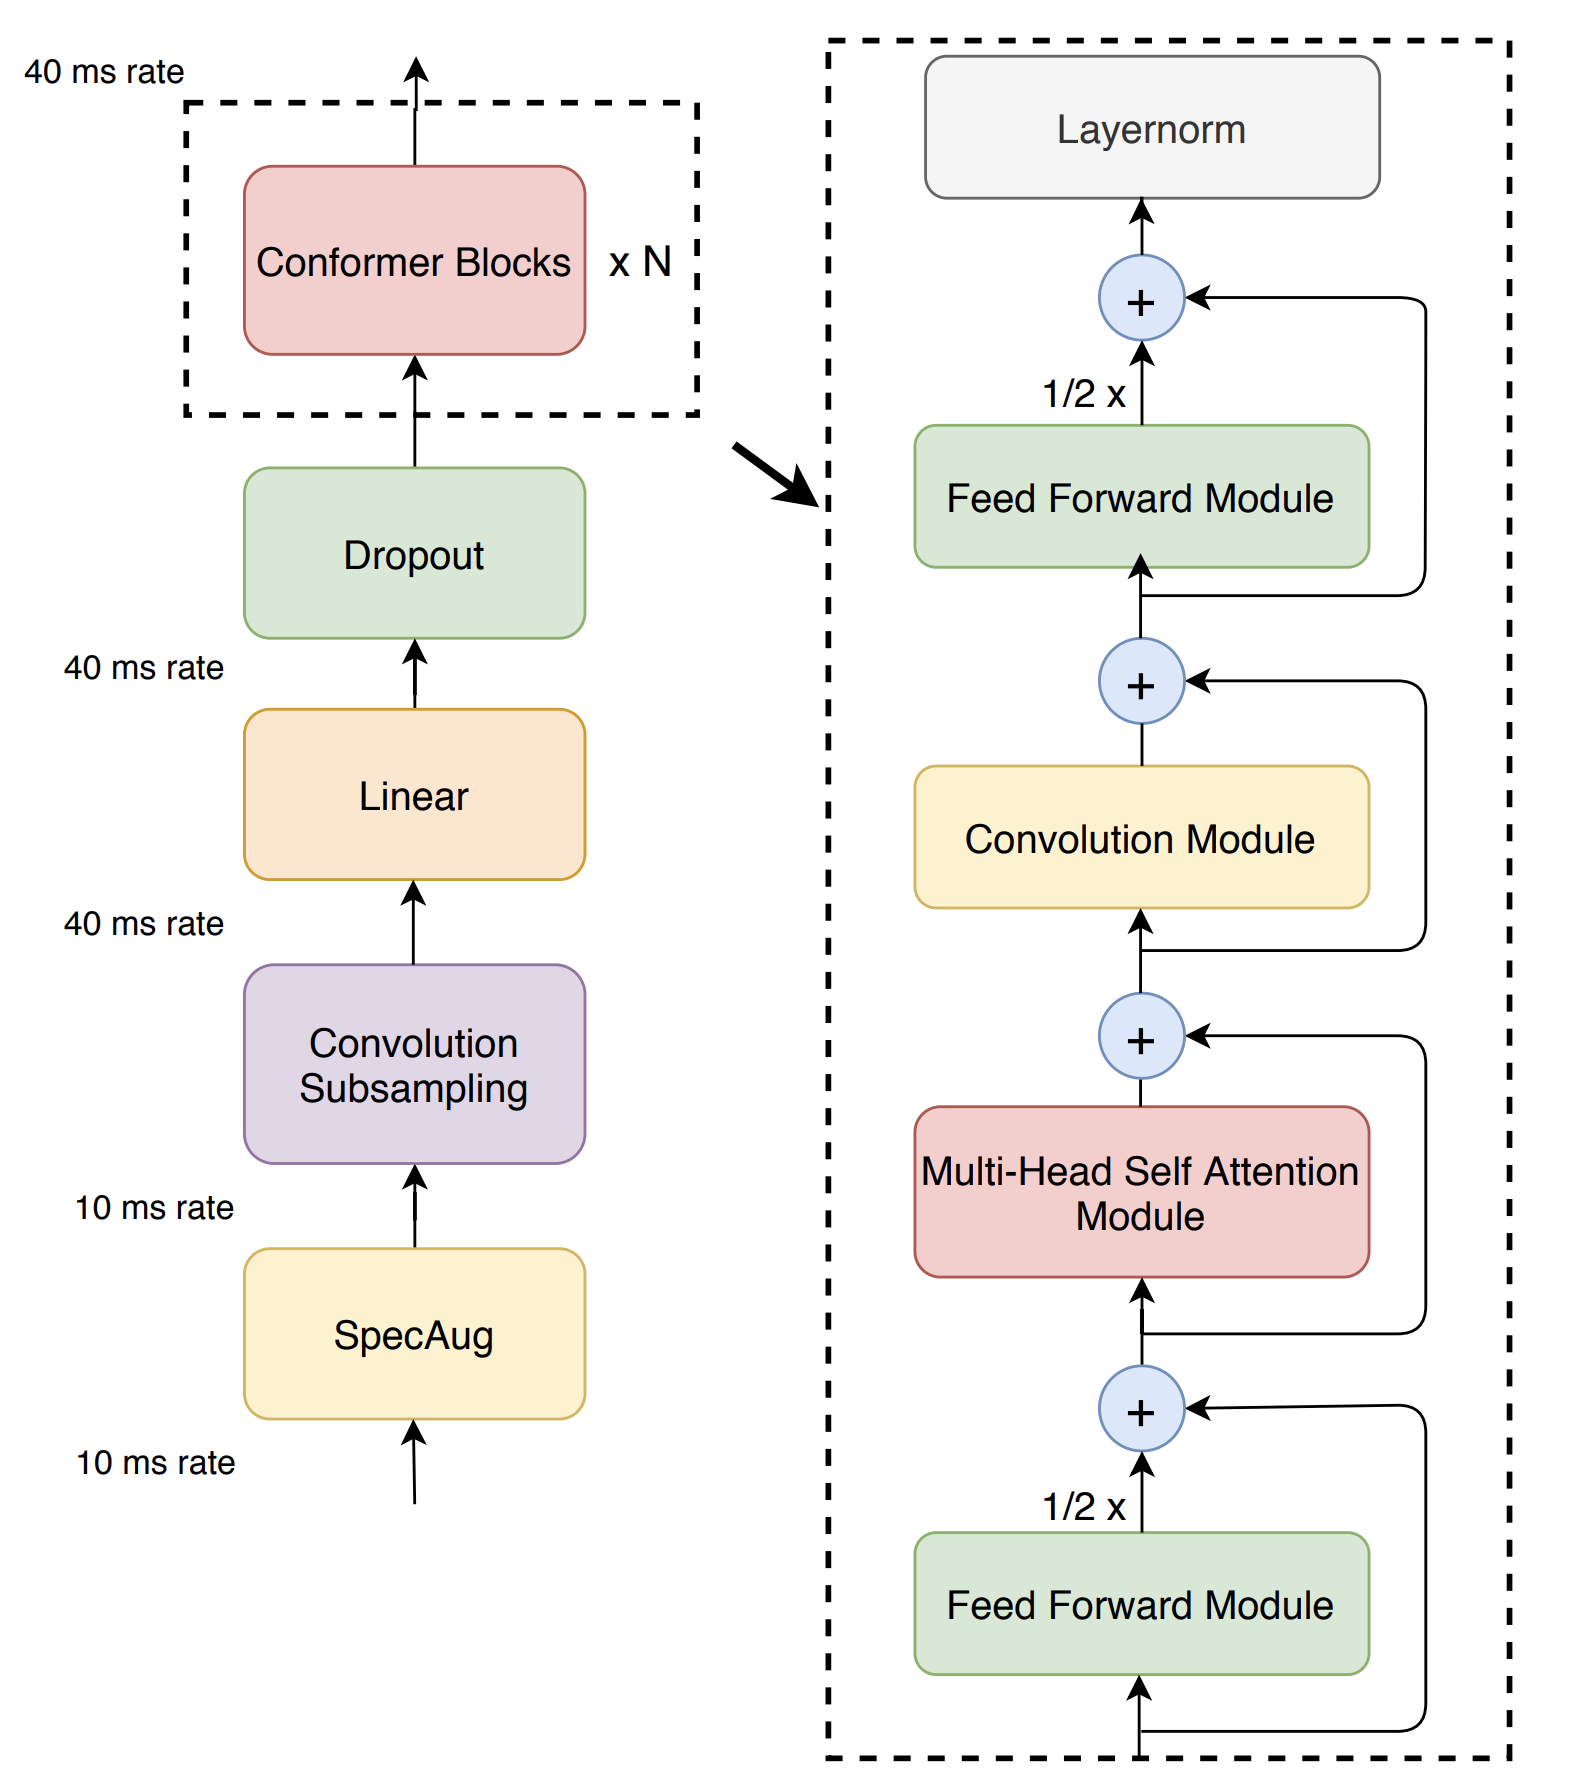

In [16]:
Conformer = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_conformer_ctc_xlarge")

[NeMo I 2024-06-03 09:53:57 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_conformer_ctc_xlarge/versions/1.10.0/files/stt_en_conformer_ctc_xlarge.nemo to /root/.cache/torch/NeMo/NeMo_2.0.0rc1/stt_en_conformer_ctc_xlarge/eff9a44c668d74bfee7b59f7def80bf4/stt_en_conformer_ctc_xlarge.nemo
[NeMo I 2024-06-03 09:54:13 common:826] Instantiating model from pre-trained checkpoint
[NeMo I 2024-06-03 09:54:18 mixins:172] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2024-06-03 09:54:18 modelPT:176] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath:
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket1/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket2/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket3/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket4/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket5/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket6/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket7/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket8/tarred_audio_manifest.json
    sample_rate: 16000
    

[NeMo I 2024-06-03 09:54:18 features:305] PADDING: 0
[NeMo I 2024-06-03 09:54:27 save_restore_connector:263] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_2.0.0rc1/stt_en_conformer_ctc_xlarge/eff9a44c668d74bfee7b59f7def80bf4/stt_en_conformer_ctc_xlarge.nemo.


In [35]:
start_conformer = time.time()
conformer_predict_transcriptions = []
for i in test_wavs:
    conformer_predict_transcriptions.append(Conformer.transcribe(audio = i, verbose = False)[0])
end_conformer = time.time()
total_conformer = end_conformer - start_conformer

**Contextnet**

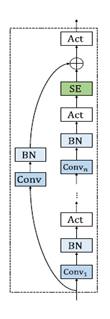

In [64]:
contextnet = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained(model_name = 'stt_en_contextnet_1024_mls')

[NeMo I 2024-06-03 11:20:55 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_contextnet_1024_mls/versions/1.0.0/files/stt_en_contextnet_1024_mls.nemo to /root/.cache/torch/NeMo/NeMo_2.0.0rc1/stt_en_contextnet_1024_mls/a4932f4d4960b3426ea49407dd5baf15/stt_en_contextnet_1024_mls.nemo
[NeMo I 2024-06-03 11:21:14 common:826] Instantiating model from pre-trained checkpoint
[NeMo I 2024-06-03 11:21:24 mixins:172] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2024-06-03 11:21:25 modelPT:176] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: false
    max_duration: 20.0
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    use_start_end_token: false
    
[NeMo W 2024-06-03 11:21:25 modelPT:183] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    use_start_end_token: false
    
[NeMo W 2024-06-03 11:21:25 modelPT:189] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-06-03 11:21:25 features:305] PADDING: 16
[NeMo I 2024-06-03 11:21:29 rnnt_models:224] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.001}
[NeMo I 2024-06-03 11:21:29 rnnt_models:224] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.001}
[NeMo I 2024-06-03 11:21:29 rnnt_models:224] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.001}
[NeMo I 2024-06-03 11:21:30 save_restore_connector:263] Model EncDecRNNTBPEModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.0.0rc1/stt_en_contextnet_1024_mls/a4932f4d4960b3426ea49407dd5baf15/stt_en_contextnet_1024_mls.nemo.


In [72]:
start_contextnet = time.time()
contextnet_predict_transcriptions = []
for i in test_wavs:
    contextnet_predict_transcriptions.append(contextnet.transcribe(audio = i, verbose = False)[0][0])
end_contextnet = time.time()
total_contextnet = end_contextnet - start_contextnet

# Метрики

**WER** word error rate

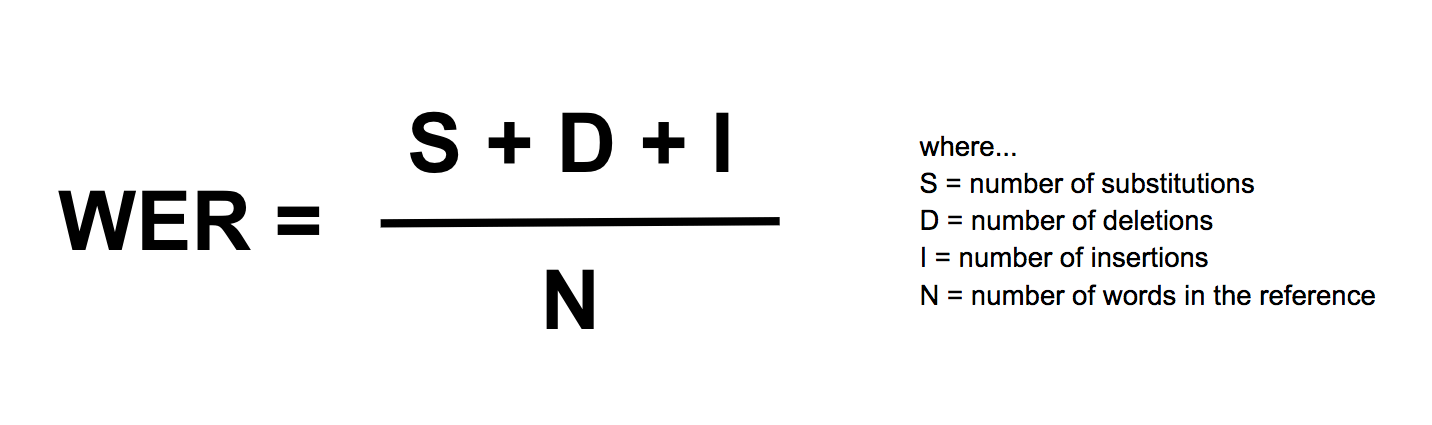

In [48]:
def wer(predicted_trans, trans):
    return nemo_asr.metrics.wer.word_error_rate(predicted_trans, trans)

**CER** character error rate

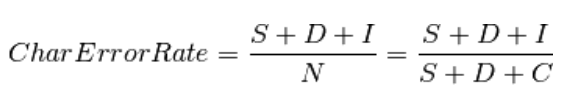

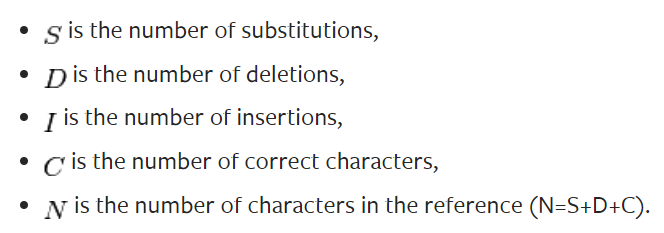

In [53]:
def cer(predicted_trans, trans):
    return nemo_asr.metrics.wer.word_error_rate(predicted_trans, trans, use_cer = True)

In [75]:
quartznet_WER = wer(quartznet_predict_transcriptions, test_transcriptions)
quartznet_CER = cer(quartznet_predict_transcriptions, test_transcriptions)
conformer_WER = wer(conformer_predict_transcriptions, test_transcriptions)
conformer_CER = cer(conformer_predict_transcriptions, test_transcriptions)
contextnet_WER = wer(contextnet_predict_transcriptions, test_transcriptions)
contextnet_CER = cer(contextnet_predict_transcriptions, test_transcriptions)

# Сравнение моделей

In [77]:
itog = pd.DataFrame({'time_predicting': [total_quartznet, total_conformer, total_contextnet],
                     'WER': [quartznet_WER, conformer_WER, contextnet_WER],
                     'CER': [quartznet_CER, conformer_CER, contextnet_CER]})
itog.index = ['Quartznet', 'Conformer', 'Contextnet']
itog

,time_predicting,WER,CER
Quartznet,45.340232,0.190463,0.084461
Conformer,84.676538,0.107369,0.054540
Contextnet,106.794576,0.135234,0.065108


# Преимущества и недостатки моделей:
1. Quartznet была представленна раньше остыльных архитектур, из минусов - данная архитектура не отлавливает долгосрочный глобальный контекст, но всё же у неё есть свои плюсы: она намного легче других архитектур, она быстрее обучается, хорошо параллелится, у неё намного меньше параметров в модели, но при этом она не так сильно проигрывает им в точности распознавания голоса. Не используется для онлайн распознавания голоса
2. Conformer - текущая SOTA модель, это сочетание механизмов self-attention и свёрточных модулей для того, чтобы взять лучшее от двух подходов. В этой архитектуре используются трансформеры для выделения контекстной информации. Очень тяжелая модель со сложной архитектурой. Можно использовать для распознавания голоса онлайн.
3. Contextnet - содержит полностью свёрточную нейросеть в качестве энкодера и RNNT loss для декодинга, учитывает контекстную информацию. Имеет очень высокую точность и простую архитектуру. Не используется для онлайн распознавания голоса

# Вывод

За последние годы мы очень сильно продвинулись в решении задачи распознавания голоса, каждый год появляются более мощные архитектуры и принципиально новые решения. Важно отметить, что под конкретную задачу подходят разные архитектуры нейросетей и "серебряной пули" в решении задачи распознавния голоса, к сожалению, пока нет. Мы сравнили модели Quartznet, Conformer, Contextnet и выяснили, какие преимущества каждая имеет перед другими.